Unique values in 'Kebangsaan' column:
+---------------------------+
|Kebangsaan                 |
+---------------------------+
|Walis & Futuna             |
|Chad                       |
|Paraguay                   |
|Macao                      |
|Ivory Coast (Pantai Gading)|
|Turki                      |
|Senegal                    |
|Sweden                     |
|Guyana                     |
|Philippines                |
|Tibet                      |
|Hongaria                   |
|Eritrea                    |
|Tonga                      |
|Djibouti                   |
|Malaysia                   |
|Singapore                  |
|Aljazair / Algeria         |
|Zaire                      |
|Malawi                     |
+---------------------------+
only showing top 20 rows

Columns and their types after encoding:
root
 |-- Kebangsaan: string (nullable = true)
 |-- Januari: integer (nullable = true)
 |-- Februari: integer (nullable = true)
 |-- Maret: integer (nullable = true)
 |-- April

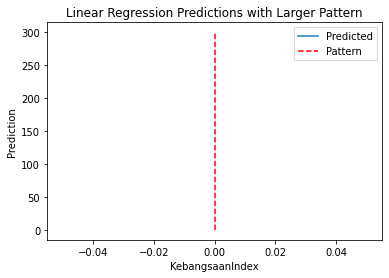

In [1]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import numpy as np

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Load dataset dari CSV
data = spark.read.csv("visitor1.csv", header=True, inferSchema=True)

# Mengganti nilai "-" dengan 0
for column in data.columns[1:]:
    data = data.withColumn(column, when(col(column) == "-", 0).otherwise(col(column)).cast("int"))

# Print unique values in 'Kebangsaan' column
print("Unique values in 'Kebangsaan' column:")
data.select("Kebangsaan").distinct().show(truncate=False)

# Replace non-numeric values in 'Kebangsaan' column with a default value (e.g., 0)
data = data.withColumn("Kebangsaan", when(col("Kebangsaan").cast("float").isNotNull(), col("Kebangsaan")).otherwise(0))

# Encode Kebangsaan column to numeric
string_indexer = StringIndexer(inputCol="Kebangsaan", outputCol="KebangsaanIndex")
model = string_indexer.fit(data)
data = model.transform(data)

# Print schema and sample data after encoding
print("Columns and their types after encoding:")
data.printSchema()
data.show()

# Memilih fitur dan target variabel
selected_columns = ['KebangsaanIndex', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']
data = data.select(selected_columns)

# Membersihkan data dari baris yang memiliki nilai null
data = data.na.drop()

# Mengubah tipe data kolom bulan ke tipe data int
for column in selected_columns[1:]:
    data = data.withColumn(column, col(column).cast("int"))

# Print informasi tentang data
print("Number of rows:", data.count())
print("Columns and their types:")
data.printSchema()
data.show()

# Check for null values in the selected features
for column in selected_columns[1:]:
    null_count = data.filter(col(column).isNull()).count()
    print(f"Number of null values in {column}: {null_count}")

# Inisialisasi VectorAssembler untuk menggabungkan fitur menjadi vektor
assembler = VectorAssembler(inputCols=selected_columns[1:], outputCol='features')

# Transformasi data menggunakan VectorAssembler
data = assembler.transform(data)

# Split data menjadi train dan test set
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Inisialisasi model regresi linear
lr = LinearRegression(featuresCol='features', labelCol='KebangsaanIndex')

lr_model = None  # Initialize lr_model outside the try-except block

try:
    # Melatih model menggunakan train set
    lr_model = lr.fit(train_data)
except Exception as e:
    print("Error during model fitting:", str(e))

# Check if lr_model is not None before proceeding
if lr_model:
    # Membuat prediksi menggunakan test set
    predictions = lr_model.transform(test_data)

    # Menampilkan hasil prediksi
    predictions.select("KebangsaanIndex", "prediction").show()

    # Evaluasi model
    evaluator = RegressionEvaluator(labelCol="KebangsaanIndex", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data =", rmse)

    # Plot the predictions
    predictions_pd = predictions.select("KebangsaanIndex", "prediction").toPandas()

    # Assigning a larger pattern to the predictions
    pattern = np.arange(0, predictions_pd.shape[0] * 5, 5)
    predictions_pd["pattern"] = pattern

    # Plotting line chart with a larger pattern
    plt.plot(predictions_pd["KebangsaanIndex"], predictions_pd["prediction"], label="Predicted")
    plt.plot(predictions_pd["KebangsaanIndex"], predictions_pd["pattern"], label="Pattern", linestyle='--', color="red")
    plt.xlabel("KebangsaanIndex")
    plt.ylabel("Prediction")
    plt.title("Linear Regression Predictions with Larger Pattern")
    plt.legend()
    plt.show()
